In [37]:

import numpy as np 
import pandas as pd
!pip install xgboost 


In [38]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('use_inf_as_na', True)
random_state = 17

In [39]:
full_df = pd.read_csv("product.csv", sep=',')
full_df.shape

(1048575, 8)

In [40]:
full_df.head()

,order_id,user_id,page_id,product,site_version,time,title,target
0,cfcd208495d565ef66e7dff9f98764da,c81e728d9d4c2f636f067f89cc14862c,6f4922f45568161a8cdf4ad2299f6d23,sneakers,desktop,11-01-2019 09:24,banner_click,0
1,c4ca4238a0b923820dcc509a6f75849b,eccbc87e4b5ce2fe28308fd9f2a7baf3,4e732ced3463d06de0ca9a15b6153677,sneakers,desktop,09-01-2019 09:38,banner_show,0
2,c81e728d9d4c2f636f067f89cc14862c,eccbc87e4b5ce2fe28308fd9f2a7baf3,5c45a86277b8bf17bff6011be5cfb1b9,sports_nutrition,desktop,09-01-2019 09:12,banner_show,0
3,eccbc87e4b5ce2fe28308fd9f2a7baf3,eccbc87e4b5ce2fe28308fd9f2a7baf3,fb339ad311d50a229e497085aad219c7,company,desktop,03-01-2019 08:58,banner_show,0
4,a87ff679a2f3e71d9181a67b7542122c,eccbc87e4b5ce2fe28308fd9f2a7baf3,fb339ad311d50a229e497085aad219c7,company,desktop,03-01-2019 08:59,banner_click,0


In [41]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 8 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   order_id      1048575 non-null  object
 1   user_id       1048575 non-null  object
 2   page_id       1048575 non-null  object
 3   product       1048575 non-null  object
 4   site_version  1048575 non-null  object
 5   time          1048575 non-null  object
 6   title         1048575 non-null  object
 7   target        1048575 non-null  int64 
dtypes: int64(1), object(7)
memory usage: 64.0+ MB


In [42]:
for i in ('order_id', 'page_id'):#iterate columns
    full_df[i] = full_df[i].fillna(0).apply(lambda x: x if x == 0 else 1)#fill nan with 0 and lamda function for nonzero to 1
    print(full_df.groupby([i]).size().sort_values(ascending=False).head(2))#group by specified column and store counts to sort descending 
    print('\n')
print(full_df.groupby(['title']).size().sort_values(ascending=False).head())#default head 5

full_df.drop(['order_id', 'page_id'], axis=1, inplace=True)

order_id
1    1048575
dtype: int64


page_id
1    1048575
dtype: int64


title
banner_show     914930
banner_click    102840
order            30805
dtype: int64


In [43]:
full_df.head()


,user_id,product,site_version,time,title,target
0,c81e728d9d4c2f636f067f89cc14862c,sneakers,desktop,11-01-2019 09:24,banner_click,0
1,eccbc87e4b5ce2fe28308fd9f2a7baf3,sneakers,desktop,09-01-2019 09:38,banner_show,0
2,eccbc87e4b5ce2fe28308fd9f2a7baf3,sports_nutrition,desktop,09-01-2019 09:12,banner_show,0
3,eccbc87e4b5ce2fe28308fd9f2a7baf3,company,desktop,03-01-2019 08:58,banner_show,0
4,eccbc87e4b5ce2fe28308fd9f2a7baf3,company,desktop,03-01-2019 08:59,banner_click,0




product
company             235185
clothes             215973
sneakers            205486
accessories         196803
sports_nutrition    195128
dtype: int64


site_version
mobile     761333
desktop    287242
dtype: int64


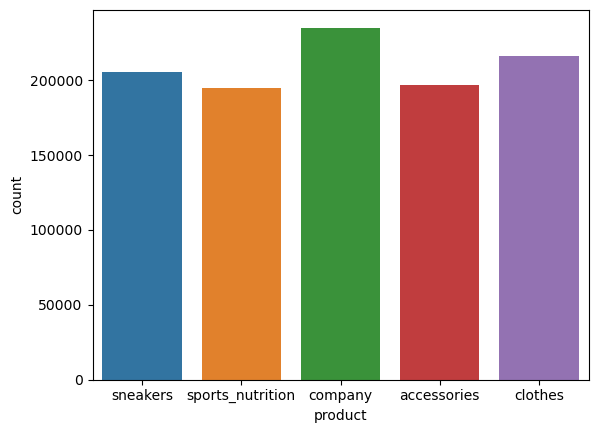

<Axes: xlabel='site_version', ylabel='count'>

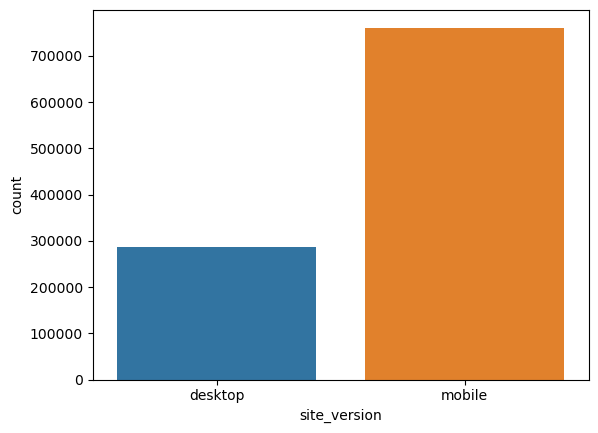

In [44]:
for i in ['product', 'site_version']:
    print('\n')
    print(full_df.groupby([i]).size().sort_values(ascending=False).head())
sns.countplot(data=full_df,x='product')
plt.show()
sns.countplot(data=full_df,x='site_version')

In [45]:
full_df = full_df.assign(num_conversion=full_df.groupby(['user_id'])['time'].rank(method='first', ascending=True))
full_df['IsBanner_click'] = full_df['title'].apply(lambda x: 1 if x == 'banner_click' else 0)
full_df['IsBanner_click'] = full_df.groupby('user_id').IsBanner_click.transform(np.mean).apply(lambda x: 0 if x == 0 else 1)
full_df['IsFirst_conversion'] = full_df['num_conversion'].apply(lambda x: 1 if x == 1 else 0)
full_df.drop(['user_id', 'title'], axis=1, inplace=True)


In [46]:
full_df.head()


,product,site_version,time,target,num_conversion,IsBanner_click,IsFirst_conversion
0,sneakers,desktop,11-01-2019 09:24,0,1.0,1,1
1,sneakers,desktop,09-01-2019 09:38,0,4.0,1,0
2,sports_nutrition,desktop,09-01-2019 09:12,0,3.0,1,0
3,company,desktop,03-01-2019 08:58,0,1.0,1,1
4,company,desktop,03-01-2019 08:59,0,2.0,1,0


In [47]:
full_df['time'] = pd.to_datetime(full_df['time'])
full_df['time_IsMorning'] = full_df['time'].apply(lambda ts: 1 if (ts.hour >= 6) and (ts.hour < 10) else 0)
full_df['time_IsDaylight'] = full_df['time'].apply(lambda ts: 1 if (ts.hour >= 10) and (ts.hour < 16) else 0)
full_df['time_IsEvening'] = full_df['time'].apply(lambda ts: 1 if (ts.hour >= 16) and (ts.hour < 23) else 0)
full_df['time_Hour'] = full_df['time'].apply(lambda ts: ts.hour)
full_df['time_Day'] = full_df['time'].apply(lambda ts: ts.day)
full_df['time_Week_Day'] = full_df['time'].apply(lambda ts: datetime.date(ts.year, ts.month, ts.day).weekday() + 1)
full_df['time_Year_Month'] = full_df['time'].apply(lambda ts: ts.year * 100 + ts.month)
full_df.drop(['time'], axis=1, inplace=True)

In [48]:
full_df['SV_IsMobile'] = full_df['site_version'].map({'desktop': 0, 'mobile': 1})
full_df.drop(['site_version'], axis=1, inplace=True)

In [49]:
full_df = pd.get_dummies(full_df, columns=['product'])


In [50]:
full_df.head()

,target,num_conversion,IsBanner_click,IsFirst_conversion,time_IsMorning,time_IsDaylight,time_IsEvening,time_Hour,time_Day,time_Week_Day,time_Year_Month,SV_IsMobile,product_accessories,product_clothes,product_company,product_sneakers,product_sports_nutrition
0,0,1.0,1,1,1,0,0,9,1,5,201911,0,0,0,0,1,0
1,0,4.0,1,0,1,0,0,9,1,7,201909,0,0,0,0,1,0
2,0,3.0,1,0,1,0,0,9,1,7,201909,0,0,0,0,0,1
3,0,1.0,1,1,1,0,0,8,1,5,201903,0,0,0,1,0,0
4,0,2.0,1,0,1,0,0,8,1,5,201903,0,0,0,1,0,0


In [51]:
access_df = full_df.drop(['product_clothes', 'product_company', 'product_sneakers', 'product_sports_nutrition'], axis=1)

In [52]:
number_records_fraud = len(full_df[full_df.target == 1])
fraud_indices = np.array(full_df[full_df.target == 1].index)

# Picking the indices of the normal classes
normal_indices = full_df[full_df.target == 0].index

# Out of the indices we picked, randomly select "x" number (number_records_fraud)
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace = False)
random_normal_indices = np.array(random_normal_indices)

# Appending the 2 indices
under_sample_indices = np.concatenate([fraud_indices,random_normal_indices])

# Under sample dataset
under_sample_data = full_df.iloc[under_sample_indices,:]

X = under_sample_data.loc[:, under_sample_data.columns != 'target']
y = under_sample_data.loc[:, under_sample_data.columns == 'target']

# Showing ratio
print("Perc. of banner click or show result: ", len(under_sample_data[under_sample_data.target == 0])/len(under_sample_data))
print("Perc. of order result: ", len(under_sample_data[under_sample_data.target == 1])/len(under_sample_data))
print("Total number of transactions in resampled data: ", len(under_sample_data))

Perc. of banner click or show result:  0.5
Perc. of order result:  0.5
Total number of transactions in resampled data:  61610


In [53]:
X.shape, y.shape

((61610, 16), (61610, 1))

In [54]:
X.head()

,num_conversion,IsBanner_click,IsFirst_conversion,time_IsMorning,time_IsDaylight,time_IsEvening,time_Hour,time_Day,time_Week_Day,time_Year_Month,SV_IsMobile,product_accessories,product_clothes,product_company,product_sneakers,product_sports_nutrition
60,1.0,1,1,0,1,0,10,3,7,201903,0,0,0,0,0,1
106,2.0,1,0,0,0,1,21,2,5,201908,0,0,0,0,1,0
107,3.0,1,0,0,0,1,19,2,3,201910,0,0,1,0,0,0
165,1.0,0,1,0,1,0,10,2,7,201906,1,0,0,0,0,1
179,1.0,1,1,0,0,1,19,2,3,201910,1,1,0,0,0,0


In [55]:
stand_X = pd.DataFrame(preprocessing.scale(X), columns=X.columns)

In [56]:
class Feat_Importance:
    df = None
    columns = None
    random_state = None
    ranks = {}
        
    def __init__(self, X, y, columns, random_state=56, show_dict='N'):
        self.X = X
        self.y = y
        self.names = columns
        self.random_state = random_state
        self.show_dict = show_dict
        
    def __rank_to_dict(self, ranks, names, order=1):
        minmax = MinMaxScaler()#normalize feature score 0-1
        ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]#normalize on specific order
        ranks = map(lambda x: round(x, 2), ranks)#round values upto 2 decimal places
        return dict(zip(names, ranks))
    
    def feat_stats(self):
        self.ranks = {}
        self.get_KBest()
        self.get_LogReg()
        self.get_XGBC()
        
    def get_KBest(self):#univariate top k based target values
        selector = SelectKBest(f_classif)#anova f
        selector.fit(self.X, self.y)#fit the model
        scores = selector.scores_#obtain calculted scores
        scores = pd.Series(scores).fillna(0)
        self.ranks["KBest"] = self.__rank_to_dict(scores, self.names)
        if self.show_dict == 'Y': 
            print('===== KBest dict =====\n', self.ranks["KBest"], '\n\n\n')
            
    def get_LogReg(self):
        model_LogRegRidge = LogisticRegression(penalty='l2', C=0.15,#l2 to avoid overfitting  
                                               random_state=self.random_state, solver='liblinear', 
                                               n_jobs=-1)
        model_LogRegRidge.fit(self.X, self.y)
        self.ranks["LogRegRidge"] = self.__rank_to_dict(list(map(float, 
                                    model_LogRegRidge.coef_.reshape(len(self.names), -1))),
                                    self.names, order=1)
        
        if self.show_dict == 'Y': 
            print('===== LogRegRidge dict =====\n', self.ranks["LogRegRidge"], '\n\n\n')
        
    
    def get_XGBC(self):
        model_XGBC = XGBClassifier(objective='binary:logistic',
                           max_depth=7, min_child_weight=5,
                           gamma=0, random_state=random_state, n_jobs=-1,
                           learning_rate=0.1, n_estimators=200)
        model_XGBC.fit(self.X, self.y)
        self.ranks["XGBC"] = self.__rank_to_dict(model_XGBC.feature_importances_, self.names)
        if self.show_dict == 'Y': 
            print('===== XGBClassifier dict =====\n', self.ranks["XGBC"], '\n\n\n')
       
    def stats_df(self):
        r = {}
        for name in self.names:
            r[name] = round(np.mean([self.ranks[method][name] for method in self.ranks.keys()]), 2)
        methods = sorted(self.ranks.keys())
        self.ranks['Mean'] = r
        methods.append('Mean')

        row_index, AllFeatures_columns = 0, ['Feature', 'Scores']
        AllFeats = pd.DataFrame(columns=AllFeatures_columns)
        for name in self.names:
            AllFeats.loc[row_index, 'Feature'] = name
            AllFeats.loc[row_index, 'Scores'] = [self.ranks[method][name] for method in methods]
            row_index += 1
        AllFeatures_only = pd.DataFrame(AllFeats.Scores.tolist(), )
        AllFeatures_only.rename(columns={0: 'KBest', 1: 'LogRegRidge', 2: 'XGB Classifier', 3: 'Mean'}, inplace=True)
        AllFeatures_only = AllFeatures_only[['KBest', 'LogRegRidge', 'XGB Classifier', 'Mean']]
        AllFeatures_compare = AllFeats.join(AllFeatures_only).drop(['Scores'], axis=1)
        return AllFeatures_compare
    
    def simple_test(self):
        x_train, x_valid, y_train, y_valid = train_test_split(self.X, self.y, test_size=0.3, random_state=random_state+37)
        mods = ('BernoulliNB', 'KNeighborsClassifier', 'RandomForestClassifier')
        for nu, model in enumerate([BernoulliNB(), KNeighborsClassifier(n_jobs=-1), 
                      RandomForestClassifier(n_jobs=-1)]):
            model.fit(x_train, y_train)
            predicted = model.predict(x_valid)
            print(mods[nu])
            print('------ accuracy ------\n', metrics.accuracy_score(y_valid, predicted))
            #print('------ confusion_matrix ------\n', metrics.confusion_matrix(y_valid, predicted))
            print('------ roc_auc_score ------\n', metrics.roc_auc_score(y_valid, predicted))
            print('\n')

In [57]:
fi = Feat_Importance(stand_X, y, stand_X.columns)
fi.feat_stats()
fi_df = fi.stats_df()
display(fi_df.sort_values(by=['Mean'], ascending=[False]))

,Feature,KBest,LogRegRidge,XGB Classifier,Mean
13,product_company,1.00,0.00,1.00,0.67
12,product_clothes,0.58,1.00,0.04,0.54
10,SV_IsMobile,0.61,0.47,0.10,0.39
1,IsBanner_click,0.09,0.89,0.03,0.34
14,product_sneakers,0.05,0.91,0.01,0.32
15,product_sports_nutrition,0.12,0.76,0.03,0.30
0,num_conversion,0.07,0.77,0.01,0.28
6,time_Hour,0.00,0.82,0.01,0.28
11,product_accessories,0.00,0.84,0.00,0.28
2,IsFirst_conversion,0.08,0.69,0.00,0.26


In [58]:
fi.simple_test()

BernoulliNB
------ accuracy ------
 0.7183898717740627
------ roc_auc_score ------
 0.7177808378092002


KNeighborsClassifier
------ accuracy ------
 0.7248823242980036
------ roc_auc_score ------
 0.7246185149115929


RandomForestClassifier
------ accuracy ------
 0.723746145106314
------ roc_auc_score ------
 0.7235605555977145




In [59]:
x_train, x_valid, y_train, y_valid = train_test_split(stand_X, y, test_size=0.3, random_state=random_state)

In [60]:
r_for = RandomForestClassifier()
print(r_for)
for_params = {'max_depth': np.arange(4, 10), 'max_features': np.arange(0.25, 0.5, 1), 'n_estimators': [30, 50, 60]}
for_grid = GridSearchCV(r_for, for_params, cv=2, n_jobs=-1)
for_grid.fit(x_train, y_train)
print('best score / best params: ', for_grid.best_score_, for_grid.best_params_)
y_pred = for_grid.predict(x_valid)
print('classification_report: \n', metrics.classification_report(y_pred, y_valid))
print('accuracy_score: ', metrics.accuracy_score(y_pred, y_valid))
print('roc_auc_score: ', metrics.roc_auc_score(y_pred, y_valid))

RandomForestClassifier()
best score / best params:  0.7545621098208919 {'max_depth': 9, 'max_features': 0.25, 'n_estimators': 30}
classification_report: 
               precision    recall  f1-score   support

           0       0.69      0.78      0.73      8178
           1       0.81      0.72      0.76     10305

    accuracy                           0.75     18483
   macro avg       0.75      0.75      0.75     18483
weighted avg       0.76      0.75      0.75     18483

accuracy_score:  0.7494995401179462
roc_auc_score:  0.7530026239319252


In [61]:
log_r = LogisticRegression()
grid_values = {'penalty': ['l2'], 'C': [0.0001, 0.001, 0.01, 0.1]}
lr_grid = GridSearchCV(log_r, param_grid=grid_values, cv=2, n_jobs=-1)
lr_grid.fit(x_train, y_train)
print('best score / best params: ', lr_grid.best_score_, lr_grid.best_params_)
y_pred = lr_grid.predict(x_valid)
print('classification_report: \n', metrics.classification_report(y_pred, y_valid))
print('accuracy_score: ', metrics.accuracy_score(y_pred, y_valid))
print('roc_auc_score: ', metrics.roc_auc_score(y_pred, y_valid))



best score / best params:  0.7337862660343291 {'C': 0.01, 'penalty': 'l2'}
classification_report: 
               precision    recall  f1-score   support

           0       0.68      0.76      0.72      8336
           1       0.78      0.71      0.74     10147

    accuracy                           0.73     18483
   macro avg       0.73      0.73      0.73     18483
weighted avg       0.74      0.73      0.73     18483

accuracy_score:  0.7305632202564519
roc_auc_score:  0.7329293277969321


In [62]:
cluster_stand_df = stand_X
cluster_stand_df['target'] = preprocessing.scale(y)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=random_state).fit(cluster_stand_df)
unique, counts = np.unique(kmeans.labels_, return_counts=True)
print(np.asarray((unique, counts)).T)

[[    0 18764]
 [    1 20648]
 [    2 22198]]


In [63]:
cluster_df = X[[i for i in stand_X.columns if i != 'target']]
cluster_df['target'] = y
cluster_df['Cluster'] = kmeans.labels_ 
cluster_df['Cluster'].value_counts(normalize=True)

2    0.360299
1    0.335140
0    0.304561
Name: Cluster, dtype: float64

In [64]:
cluster_df.groupby('Cluster').mean().sort_values(by=['target'], ascending=False)

,num_conversion,IsBanner_click,IsFirst_conversion,time_IsMorning,time_IsDaylight,time_IsEvening,time_Hour,time_Day,time_Week_Day,time_Year_Month,SV_IsMobile,product_accessories,product_clothes,product_company,product_sneakers,product_sports_nutrition,target
Cluster,,,,,,,,,,,,,,,,,
2,3.057077,0.450221,0.337147,0.000000,0.0,0.926615,18.947878,13.026714,3.940760,201903.830615,0.584647,0.190738,0.336111,0.102892,0.233670,0.136589,0.538427
0,2.985664,0.448678,0.357280,0.000000,1.0,0.000000,12.426881,12.934609,3.961096,201903.865434,0.601471,0.184182,0.326530,0.117246,0.227617,0.144425,0.485824
1,2.985858,0.450697,0.362747,0.586836,0.0,0.000000,5.613038,13.014868,3.955637,201903.811652,0.605095,0.182342,0.320903,0.121707,0.232081,0.142968,0.471571


IsBanner_click


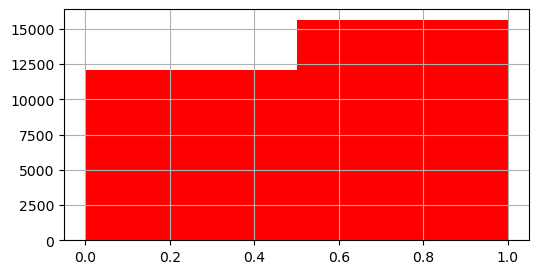

IsFirst_conversion


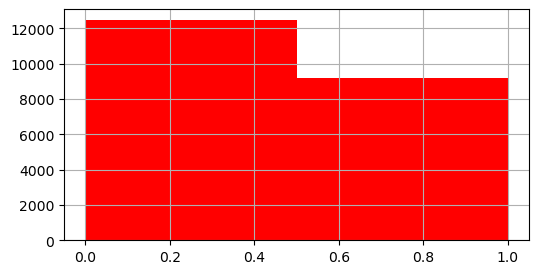

time_IsMorning


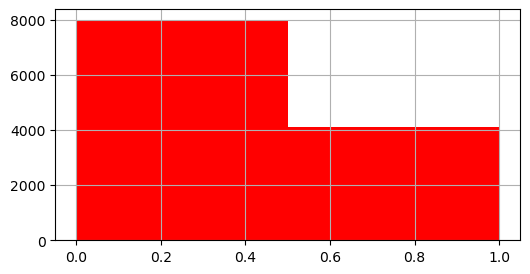

time_IsDaylight


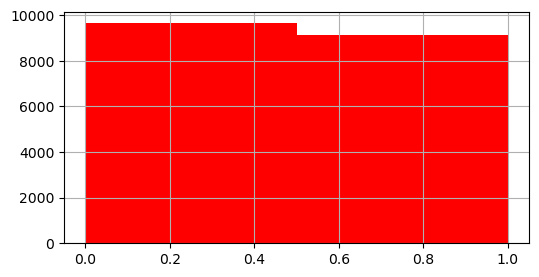

time_IsEvening


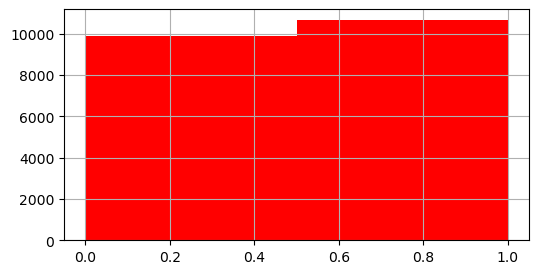

SV_IsMobile


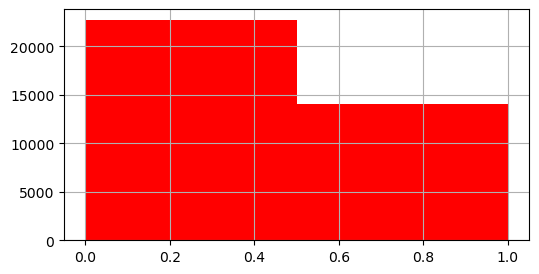

In [65]:
feat = [f for f in cluster_df.columns if 'Is' in f]
for i in feat:
    print(i)
    plt.figure()
    tmp = cluster_df[cluster_df[i] == 1]
    tmp['target'].hist(figsize=(6, 3), bins=2, color = 'red')
    plt.show();

time_IsMorning


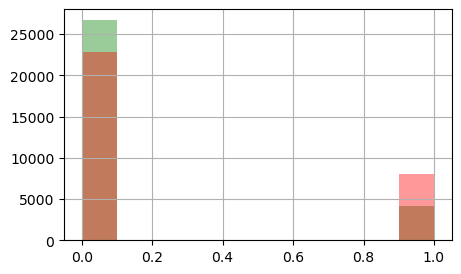

time_IsDaylight


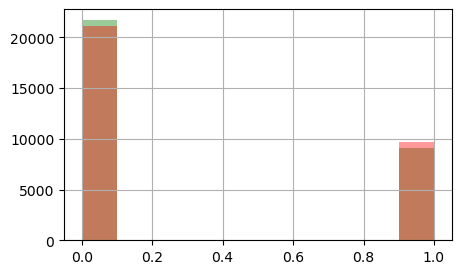

time_IsEvening


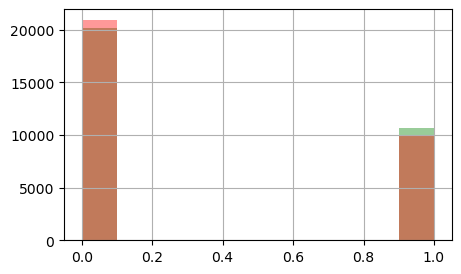

time_Hour


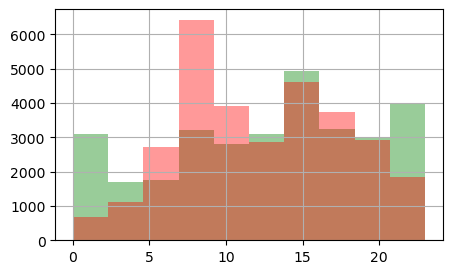

time_Day


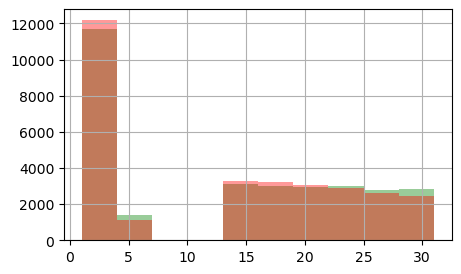

time_Week_Day


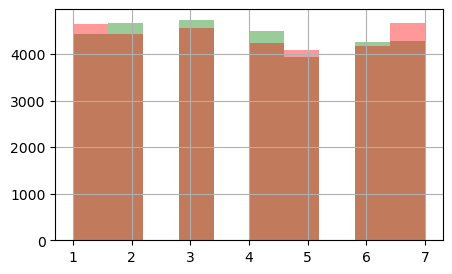

time_Year_Month


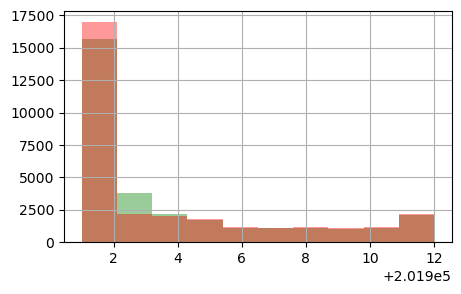

In [66]:
feat = [f for f in cluster_df.columns if 'time' in f]
for i in feat:
    print(i)
    plt.figure()
    cluster_df[cluster_df['target'] == 1][i].hist(figsize=(5, 3), alpha=0.4, color = 'green')
    cluster_df[cluster_df['target'] == 0][i].hist(figsize=(5, 3), alpha=0.4, color = 'red')
    plt.show();